<a href="https://colab.research.google.com/github/Ioncrade/TwitterHashtag_SA/blob/main/Twitter_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [58]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
# from keras.preprocessing.text import Tokenizer
# from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer # Changed import to use tensorflow.keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [59]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [60]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
!pip install Keras-Preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

100%|██████████| 80.9M/80.9M [00:04<00:00, 17.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kazanova/sentiment140/versions/2


In [61]:

df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [62]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [63]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 457 ms, sys: 894 µs, total: 458 ms
Wall time: 454 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

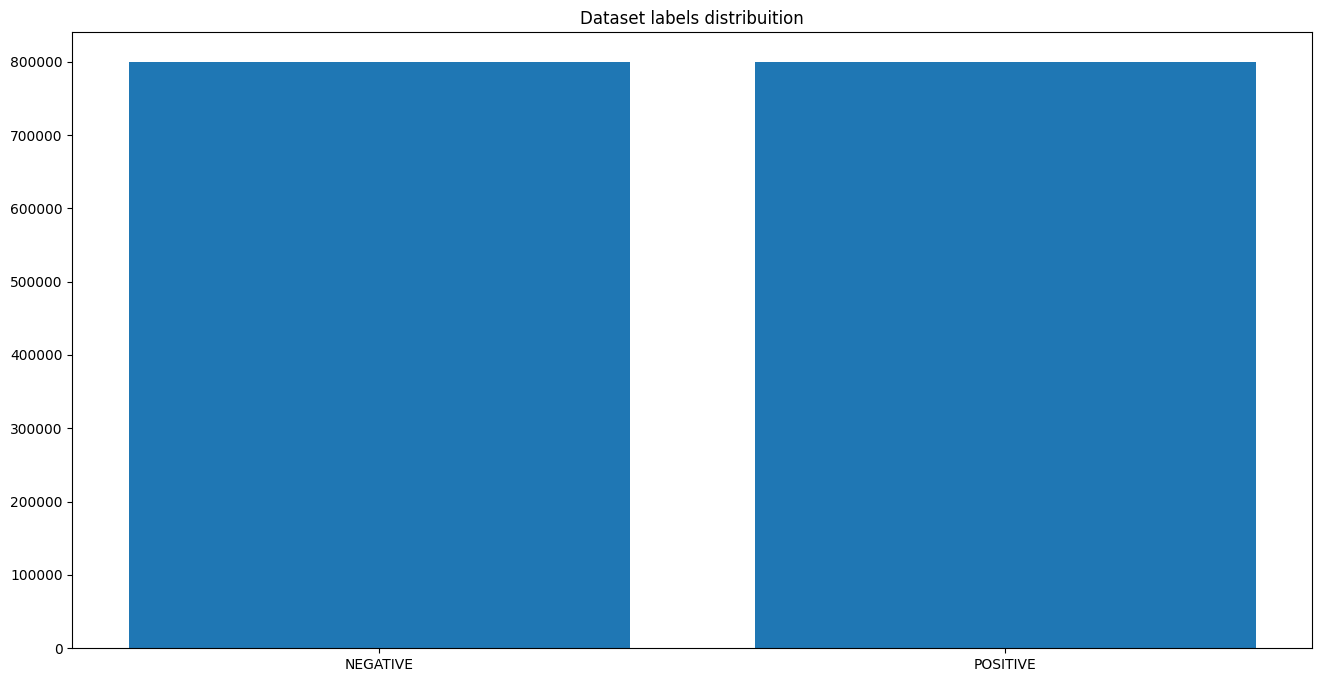

In [64]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [65]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")


In [66]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 1min 8s, sys: 316 ms, total: 1min 9s
Wall time: 1min 20s


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 4.23 s, sys: 394 ms, total: 4.62 s
Wall time: 4.65 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.index_to_key

# Get the size of the vocabulary
vocab_size = len(words)

print("Vocab size:", vocab_size)

Vocab size: 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 20min 23s, sys: 5.77 s, total: 20min 28s
Wall time: 12min 50s


(263130128, 295270528)

In [ ]:
similar_words = w2v_model.wv.most_similar("love", topn=10)
print("Top 10 words similar to 'love':", similar_words)


Top 10 words similar to 'love': [('luv', 0.5699895620346069), ('loves', 0.5537071228027344), ('loved', 0.5387433767318726), ('adore', 0.5063791275024414), ('amazing', 0.5046049356460571), ('looove', 0.494038850069046), ('loveee', 0.4680235683917999), ('awesome', 0.4620443284511566), ('lovee', 0.4519224166870117), ('miss', 0.4353114366531372)]


In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 21.2 s, sys: 255 ms, total: 21.5 s
Wall time: 21.7 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 25.8 s, sys: 541 ms, total: 26.4 s
Wall time: 26.6 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      87,125,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,125,700 (332.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 87,125,700 (332.36 MB)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5, mode='max')]

In [67]:
import tensorflow as tf

In [ ]:
with tf.device('/GPU:0'):  # Use '/GPU:1' for the second GPU, etc.
    history = model.fit(
        x_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
        verbose=1,
        callbacks=callbacks
    )

Epoch 1/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 393s 349ms/step - accuracy: 0.7633 - loss: 0.4865 - val_accuracy: 0.7834 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 2/8


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 440s 347ms/step - accuracy: 0.7684 - loss: 0.4772 - val_accuracy: 0.7859 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 3/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 444s 349ms/step - accuracy: 0.7721 - loss: 0.4725 - val_accuracy: 0.7869 - val_loss: 0.4514 - learning_rate: 0.0010
Epoch 4/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 440s 347ms/step - accuracy: 0.7740 - loss: 0.4691 - val_accuracy: 0.7886 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 5/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 393s 349ms/step - accuracy: 0.7746 - loss: 0.4676 - val_accuracy: 0.7883 - val_loss: 0.4497 - learning_rate: 0.0010
Epoch 6/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 443s 350ms/step - accuracy: 0.7759 - loss: 0.4650 - val_accuracy: 0.7898 - val_loss: 0.4470 - learning_rate: 0.0010
Epoch 7/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 463s 369ms/step - accuracy: 0.7766 - loss: 0.4638 - val_accuracy: 0.7902 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 8/8
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 421s 350ms/step - accuracy:

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 157ms/step - accuracy: 0.7910 - loss: 0.4446

ACCURACY: 0.7908968925476074
LOSS: 0.4451732337474823
CPU times: user 58.2 s, sys: 5.78 s, total: 1min 4s
Wall time: 1min 22s


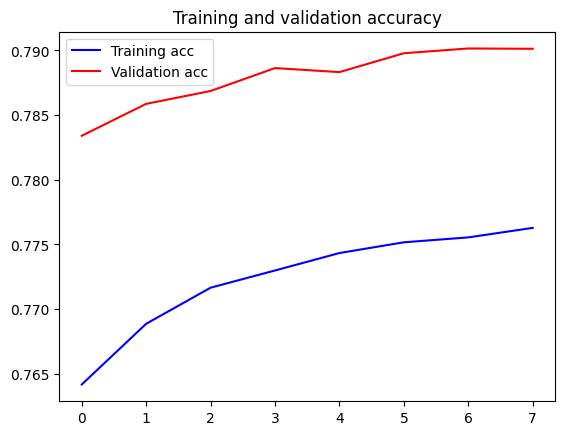

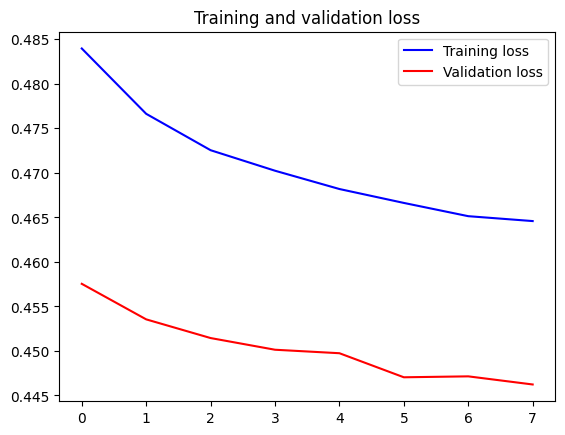

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I hate the rain")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


<ipython-input-46-b5342eec6255>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return {"label": label, "score": float(score),


{'label': 'NEGATIVE',
 'score': 0.00801369920372963,
 'elapsed_time': 0.37288880348205566}

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step
CPU times: user 11.7 s, sys: 1.87 s, total: 13.5 s
Wall time: 42 s


In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

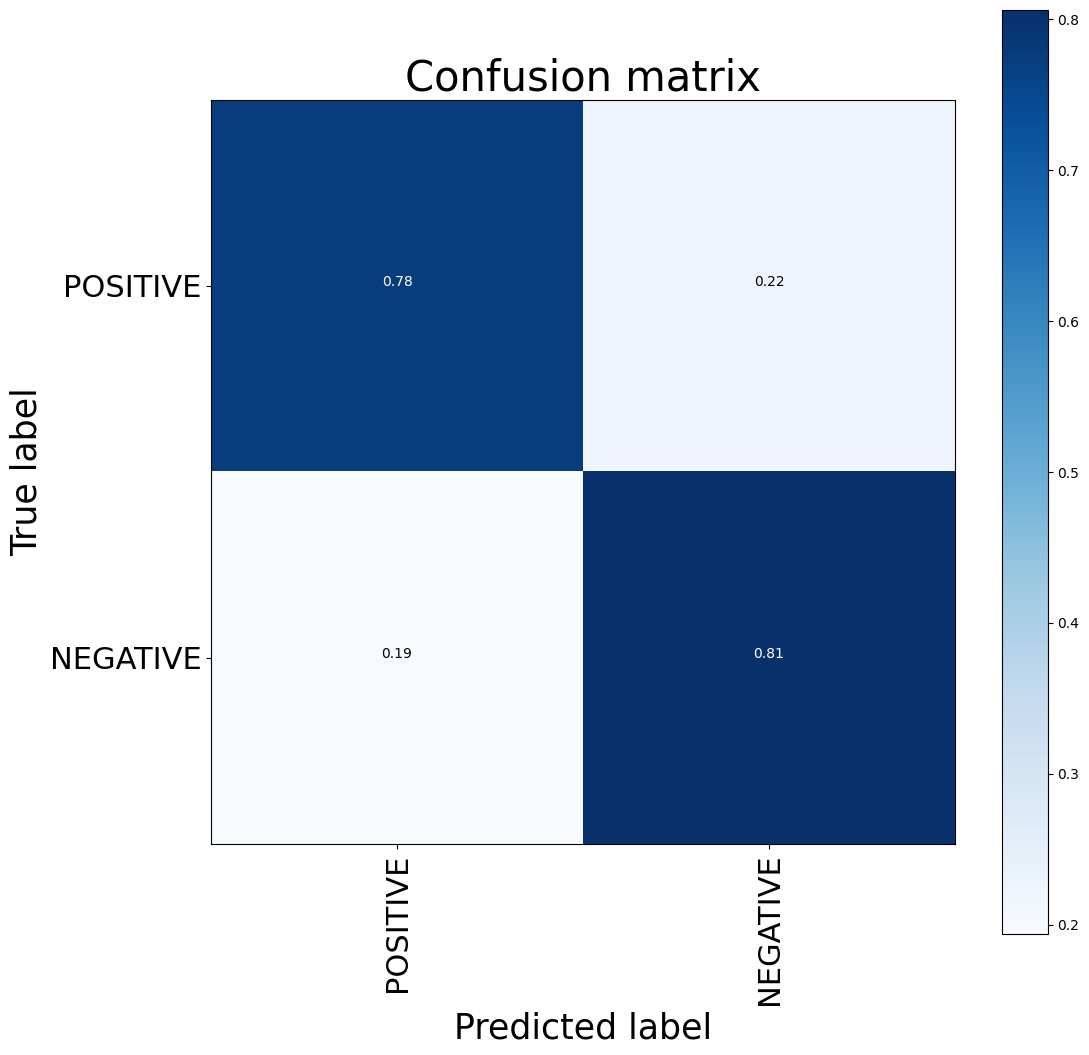

CPU times: user 1.43 s, sys: 226 ms, total: 1.65 s
Wall time: 1.41 s


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

              precision    recall  f1-score   support

    NEGATIVE       0.80      0.78      0.79    159494
    POSITIVE       0.78      0.81      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.790896875

In [ ]:
model.save('/content/drive/MyDrive/Twitter/twitter_sentiment_model.h5')

In [ ]:
model.save('/content/drive/MyDrive/Twitter/twitter_sentiment_model_2.hdf5')

In [ ]:
model.save('/content/drive/MyDrive/Twitter/twitter_sentiment_model_3.keras')